<a href="https://colab.research.google.com/github/pherathm/DATA110/blob/main/DATA201_PROJECT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**DATA 201 - PROJECT2**

**INTRODUCTION**

The National Health and Nutrition Examination Survey (NHANES) dataset was created to assess the health and nutritional status of adults and children in the United States. It serves as a key source of information for public health policies, medical research, and national health benchmarks.

The NHANES program combines interviews and physical examinations to assess the health and nutritional status of adults and children in the United States. This specific subset focuses on variables that are predictive of an individual’s age group—categorized as either senior (age ≥ 60) or non-senior (age < 60)—based on various biological, physical, and lifestyle indicators.

**DATASET OVERVIEW**

Total Rows: 2,278

Target Variable: age_group (Senior / Non-Senior)

| Variable     | Description                                                                                   |
|--------------|-----------------------------------------------------------------------------------------------|
| `SEQN`       | Respondent Sequence Number                                                                    |
| `age_group`  | Age group classification (`Senior` if age ≥ 65, else `Non-Senior`)                            |
| `RIDAGEYR`   | Respondent's age in years                                                                     |
| `RIAGENDR`   | Gender of the respondent (1 = Male, 2 = Female)                                               |
| `PAQ605`     | Physical activity: Moderate/Vigorous recreational activity in a typical week (1 = Yes, 2 = No, 7/9 = Missing/Refused) |
| `BMXBMI`     | Body Mass Index (BMI)                                                                         |
| `LBXGLU`     | Blood glucose (mg/dL) after fasting                                                           |
| `DIQ010`     | Diagnosed with diabetes? (1 = Yes, 2 = No, 3 = Borderline, 7/9 = Missing/Refused)             |
| `LBXGLT`     | Oral glucose tolerance test result (mg/dL)                                                    |
| `LBXIN`      | Blood insulin level (µU/mL)                                                                   |

**DATA LOADING AND PREPARATION**

In [28]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Load the data set
df=pd.read_csv('https://raw.githubusercontent.com/pherathm/DATA110/refs/heads/main/NHANES_age_prediction.csv')

# First few rows
df.head()


,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564,Adult,61,2,2,35.7,110,2,150,14.91
1,73568,Adult,26,2,2,20.3,89,2,80,3.85
2,73576,Adult,16,1,2,23.2,89,2,68,6.14
3,73577,Adult,32,1,2,28.9,104,2,84,16.15
4,73580,Adult,38,2,1,35.9,103,2,81,10.92


Here, we are going to change the columns' names for our analysis to be easier.

In [29]:
df.rename(columns={
    'SEQN': 'ID',
    'age_group': 'AgeGroup',
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Gender',
    'PAQ605': 'PhysicalActivity',
    'BMXBMI': 'BMI',
    'LBXGLU': 'FastingGlucose',
    'DIQ010': 'DiabetesStatus',
    'LBXGLT': 'OralGlucose',
    'LBXIN': 'InsulinLevel'
}, inplace=True)

df.head()

,ID,AgeGroup,Age,Gender,PhysicalActivity,BMI,FastingGlucose,DiabetesStatus,OralGlucose,InsulinLevel
0,73564,Adult,61,2,2,35.7,110,2,150,14.91
1,73568,Adult,26,2,2,20.3,89,2,80,3.85
2,73576,Adult,16,1,2,23.2,89,2,68,6.14
3,73577,Adult,32,1,2,28.9,104,2,84,16.15
4,73580,Adult,38,2,1,35.9,103,2,81,10.92


In [39]:
# Check data types of each column
print(df.dtypes)

ID                    int64
AgeGroup             object
Age                   int64
Gender                int64
PhysicalActivity    float64
BMI                 float64
FastingGlucose        int64
DiabetesStatus        int64
OralGlucose           int64
InsulinLevel        float64
dtype: object


In [40]:
# Check for missing values
df.isnull().sum()

,0
ID,0
AgeGroup,0
Age,0
Gender,0
PhysicalActivity,1
BMI,0
FastingGlucose,0
DiabetesStatus,0
OralGlucose,0
InsulinLevel,0


In [42]:
# Remove rows where 'PhysicalActivity' has missing values
df_cleaned = df.dropna(subset=['PhysicalActivity'])


In [43]:
# Check if there are still any missing values in the 'PhysicalActivity' column
print(df_cleaned.isnull().sum())

ID                  0
AgeGroup            0
Age                 0
Gender              0
PhysicalActivity    0
BMI                 0
FastingGlucose      0
DiabetesStatus      0
OralGlucose         0
InsulinLevel        0
dtype: int64


In [44]:
# Convert Gender and PhysicalActivity to binary
df['Gender'] = df['Gender'].map({1: 'Male', 2: 'Female'})
df['PhysicalActivity'] = df['PhysicalActivity'].replace({7: np.nan, 9: np.nan})
df['DiabetesStatus'] = df['DiabetesStatus'].replace({7: np.nan, 9: np.nan})


In [45]:
# Convert categorical values to numerical
df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0})
df['PhysicalActivity'] = df['PhysicalActivity'].map({1: 1, 2: 0})
df['DiabetesStatus'] = df['DiabetesStatus'].map({1: 1, 2: 0, 3: 2})

**EXPLATORY DATA ANALYSIS**

1. Histograms to check the distributions of numerical variables

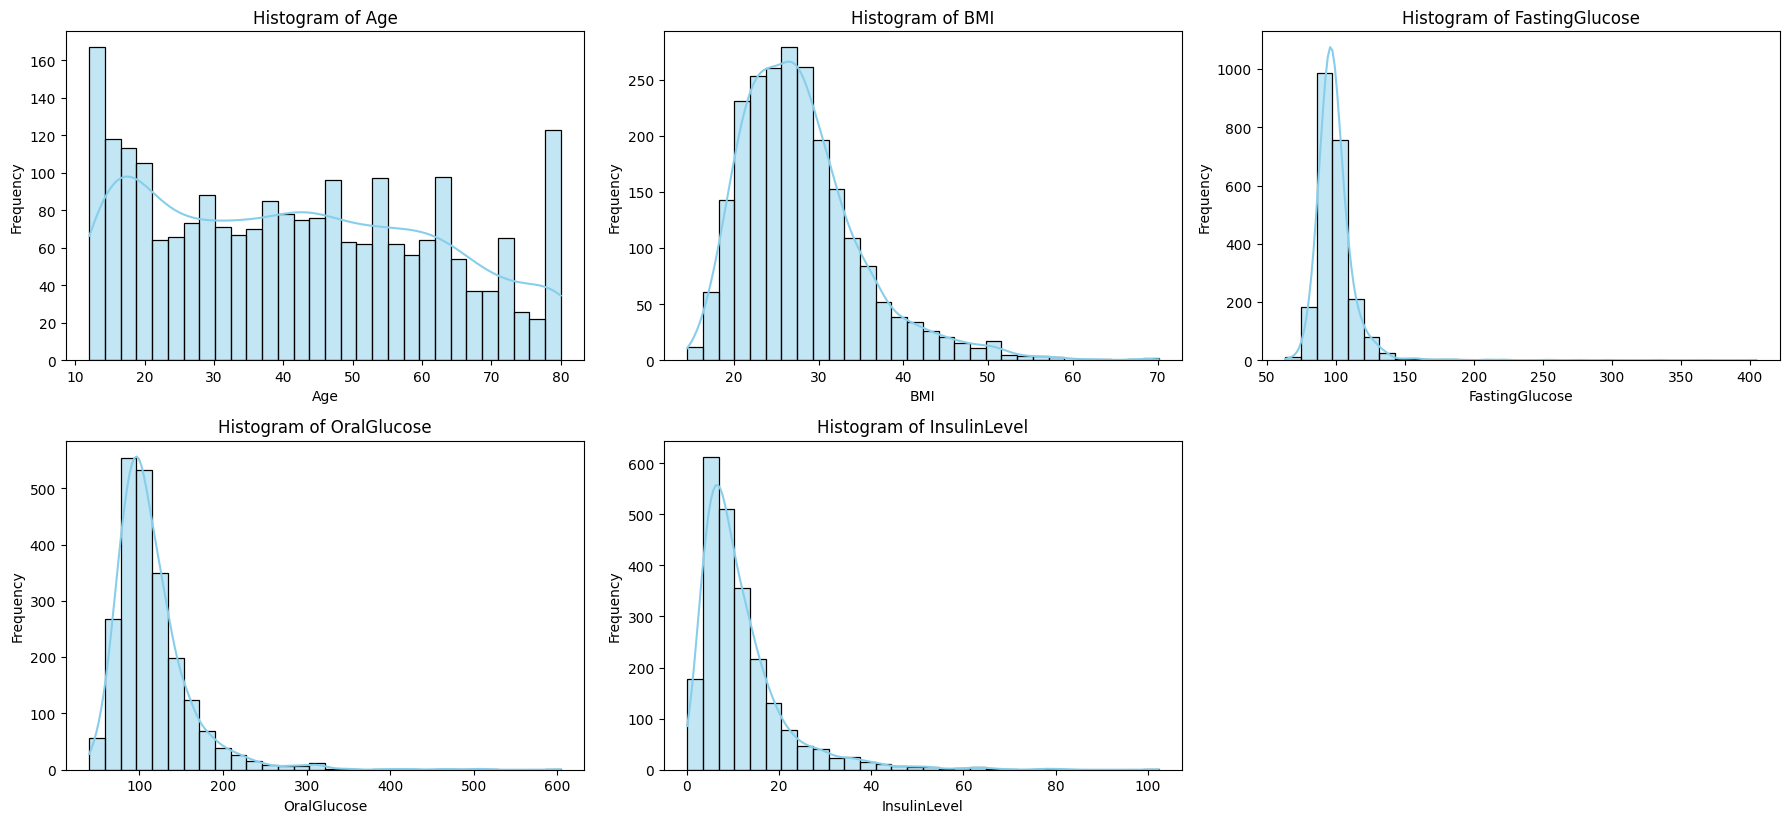

In [60]:
# Plot histograms for all numerical variables
num_columns = ['Age', 'BMI', 'FastingGlucose', 'OralGlucose', 'InsulinLevel']

# Plot
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(num_columns):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=30, color='skyblue')
    axes[i].set_title(f'Histogram of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Remove any extra subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

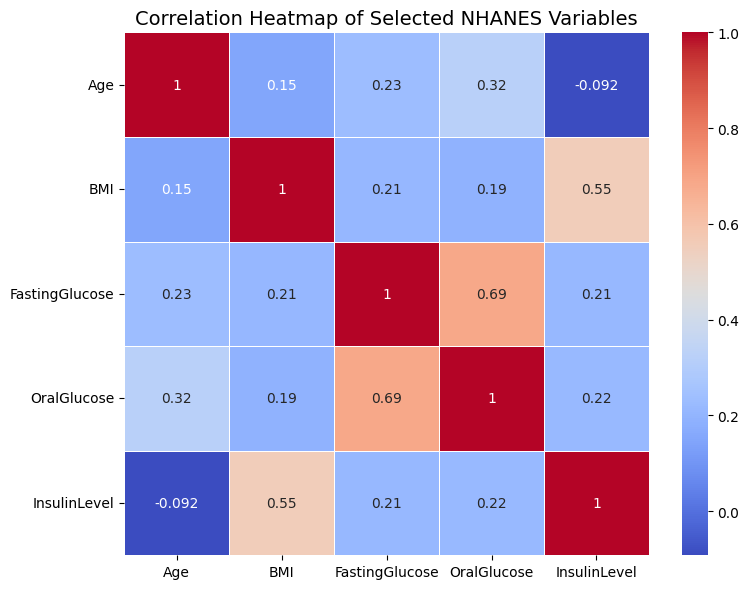

In [47]:
# Use only the numerical columns for correlation
selected_columns = ['Age', 'BMI', 'FastingGlucose', 'OralGlucose', 'InsulinLevel']
corr_matrix = df[selected_columns].corr()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap of Selected NHANES Variables", fontsize=14)
plt.tight_layout()
plt.show()


**USE SCIKIT-LEARN LINEAR REGRESSION TO TRAIN, TEST AND PREDICT A NUMERICAL TARGET VARIABLE. USE APPROPRIATE METRIC AND INTERPRET THE MEANING OF THE SCORE**

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Define the feature matrix and target variable
X = df_cleaned[['Gender', 'PhysicalActivity', 'BMI', 'FastingGlucose', 'DiabetesStatus', 'OralGlucose', 'InsulinLevel']]
y = df_cleaned['Age']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

#  evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error (MSE):", round(mse, 2))
print("Root Mean Squared Error (RMSE):", round(rmse, 2))
print("R² Score:", round(r2, 4))


Mean Squared Error (MSE): 357.94
Root Mean Squared Error (RMSE): 18.92
R² Score: 0.0838


**Interpretation**

**Mean Squared Error**

MSE = 348.39
The Mean Squared Error measures the average squared difference between the predicted and actual values. In this case, the MSE of 348.39 means that, on average, the squared errors of the model's predictions are about 348.39. A smaller MSE indicates a better model, but this value is large, so it suggests the model has substantial prediction errors.

**Root Mean Squared Error**

RMSE = 18.67
The RMSE is the square root of the MSE, and it provides an interpretable measure of error in the same units as the target variable (in this case, age). With an RMSE of 18.67, this means that the typical error in predicting the age is around 18.67 years.

**R² Score**

R² = 0.1649
The R² score tells us the proportion of the variance in the target variable (age) that is explained by the model. An R² value of 0.1649 means that only 16.49% of the variation in age can be explained by the model using the provided features. This suggests that the model doesn't explain much of the variance. It indicates that the current features may not be highly predictive of age.



**PLOT A HISTOGRAM OF THE RESIDUALS AND CHECK IF THEY HAVE A GAUSSIAN DISTRIBUTION**

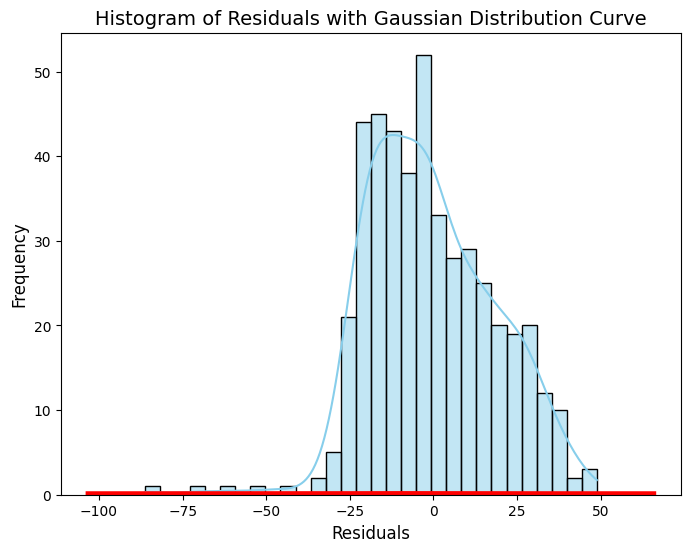

In [57]:
# Calculate residuals
residuals = y_test - y_pred

# histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='skyblue')

plt.title('Histogram of Residuals with Gaussian Distribution Curve', fontsize=14)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

#normal distribution curve for comparison
sns.kdeplot(residuals, color='red', linewidth=5)

plt.show()

**SCATTERPLOT OF PREDICTED VALUES AND RESIDUALS TO CHECK ASSUMPTION OF
HOMOSCEDASTICITY**

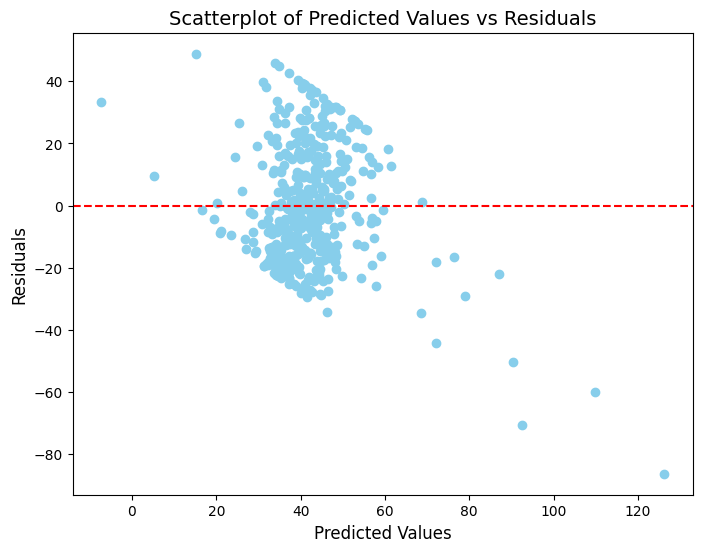

In [58]:
# Scatterplot of predicted values vs residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, color='skyblue')


plt.title('Scatterplot of Predicted Values vs Residuals', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)

plt.axhline(0, color='red', linestyle='--')

plt.show()

**INTERPRET THE COEFFICIENTS OF THE LINEAR REGRESSION**

In [59]:
coefficients = model.coef_
features = X.columns

# Make a DataFrame for visualization
coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': coefficients
})

print(coef_df)


            Feature  Coefficient
0            Gender     0.598193
1  PhysicalActivity    -1.136966
2               BMI     0.708293
3    FastingGlucose     0.084138
4    DiabetesStatus     4.897686
5       OralGlucose     0.129217
6      InsulinLevel    -0.676884


**Linear Regression Equation (Predicting Age)**

###**Age =0.598⋅Gender - 1.137⋅PhysicalActivity + 0.708⋅BMI + 0.084⋅FastingGlucose + 4.898⋅DiabetesStatus + 0.129⋅OralGlucose - 0.677⋅InsulinLevel + C**


**Interpretation of Coefficients**

1. Gender (0.598)

Being male (if encoded as 1) increases predicted age by about 0.6 years compared to female (if encoded as 0).

2. Physical Activity (-1.137)

Higher physical activity is associated with a decrease in predicted age by about 1.14 years.

3. BMI (0.708)

For each 1-unit increase in BMI, the predicted age increases by approximately 0.71 years.

4. Fasting Glucose (0.084)

A unit increase in fasting glucose increases the predicted age by 0.084 years, a relatively small effect.

5. Diabetes Status (4.898)

Having diabetes (if encoded as 1) increases predicted age by approximately 4.9 years compared to not having diabetes.

6. Oral Glucose (0.129)

For each additional unit in oral glucose, predicted age increases by 0.13 years.

7. Insulin Level (-0.677)

For each additional unit in insulin level, predicted age decreases by about 0.68 years.